In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../../scripts/')
from common_funcs import *

# GEX

In [3]:
species = ['human', 'macaque', 'marmoset', 'mouse']

In [4]:
orthologs = pd.read_csv('../../data/ref/four_species_orthologous_protein_coding_genes_1to1_filtered.txt', sep='\t')

In [5]:
def subset_orthologs(df_, ortholog_table, specie):
    df_use = df_.reindex(ortholog_table[specie + '_gene'])
    df_use.index = ortholog_table['human_gene']
    return df_use

In [6]:
percent_expressed = {specie : subset_orthologs(pd.read_csv('../../data/processed/gex_percent_expressed/{}/all_percent_aggregate.tsv'.format(specie),
                                sep='\t').set_index('Unnamed: 0'), orthologs, specie) for specie in species}

In [7]:
x = percent_expressed['mouse']

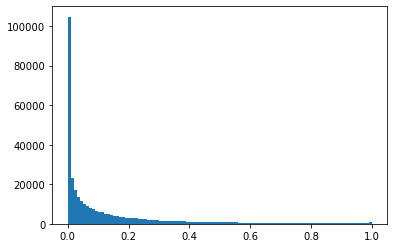

In [8]:
_ = plt.hist(x.values.flat, bins = 100)

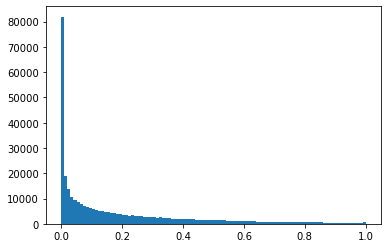

In [9]:
_ = plt.hist(percent_expressed['human'].values.flat, bins = 100)

In [10]:
clusts = open('../../data/ref/cluster_list.txt').read().split('\n')

In [11]:
test_types = !ls ../../data/outputs/gex_de_results/

In [12]:
tests = test_types

In [13]:
in_f = '../../data/outputs/gex_de_results/{0}/{1}_v_{2}_{3}.tsv'

In [14]:
out_f = '../../data/outputs/gex_de_results/{0}/aggregate/{1}_v_{2}_logfc.tsv'

# aggregate fold change GEX

In [15]:
clusts = open('../../data/ref/cluster_list.txt', 'r').read().strip('\n').split('\n')

In [16]:
spec_use = species + ['all']

In [17]:
for test in tests:
    for spec1 in species:
        for spec2 in spec_use:
            if spec1 == spec2:
                continue
            dfs = []
            for clust in clusts:
                f_use = in_f.format(test, spec1, spec2, clust)
                dat = pd.read_csv(f_use, sep='\t')
                dfs.append(dat['logFC'])
                # !wc -l $f_use
            df_out = pd.concat(dfs, axis=1)
            df_out.columns = clusts
            df_out.to_csv(out_f.format(test, spec1, spec2), sep='\t')

# aggregate gene lists for go

In [18]:
out_go_pair = '../../data/processed/gene_lists_for_go/divergent/pairwise/{0}_v_{1}_{2}_{3}_test_{4}.txt'
out_go_specific = '../../data/processed/gene_lists_for_go/divergent/{0}/{1}_{2}_test_{3}.txt'

In [19]:
bg_genes = '../../data/processed/gene_lists_for_go/divergent/background_{}.txt'

In [20]:
fdr_thresh = .001/120
percent_thresh = .15
nums = []
for test in tests:
    for clust in clusts:
        for spec1 in species:
            spec1_percent = percent_expressed[spec1][clust]
            spec_list_up = []
            spec_list_down = []
            spec_list_mixed = []
            for spec2 in species:
                # print(spec1, spec2)
                if spec1 == spec2:
                    continue
                spec2_percent = percent_expressed[spec2][clust]
                
                f_use = in_f.format(test, spec1, spec2, clust)
                dat = pd.read_csv(f_use, sep='\t')
                sig_up = dat.index[(dat.FDR < fdr_thresh) & (dat.logFC >np.log2(3))].values
                sig_up = spec1_percent.index[(spec1_percent > .15) & spec1_percent.index.isin(sig_up)].values.tolist()
                sig_down = dat.index[(dat.FDR < fdr_thresh) & (dat.logFC < np.log2(3))].values
                sig_down = spec2_percent.index[(spec2_percent > .15) & spec2_percent.index.isin(sig_down)].values.tolist()
                
                # print('here')
                spec_list_up.append(sig_up)
                spec_list_down.append(sig_down)
                spec_list_mixed.append(sig_up + sig_down)
                # spec_list_signs.append([True] * len(sig_up) + [False]*len(sig_down))
                save_list(out_go_pair.format(spec1, spec2, clust, 'down', test), sig_down)
                save_list(out_go_pair.format(spec1, spec2, clust, 'up', test), sig_up)
            species_spec_up = list_intersection(spec_list_up)
            species_spec_down = list_intersection(spec_list_down)
            species_spec_mixed = np.setdiff1d(np.setdiff1d(list_intersection(spec_list_mixed),
                                              species_spec_up),
                                              species_spec_down)
            save_list(out_go_specific.format(spec1, clust, 'up', test), species_spec_up)
            save_list(out_go_specific.format(spec1, clust, 'down', test), species_spec_down)
            save_list(out_go_specific.format(spec1, clust, 'mixed', test), species_spec_mixed)
            # print(spec1)
            nums.append([clust, spec1, test, len(species_spec_up), len(species_spec_down), len(species_spec_mixed)])
        background = dat.index.values
        if test == 'lrt':
            # print(clust, len(background))
            save_list(bg_genes.format(clust), background)

# get genes DE in a single cell type

In [21]:
out_go_specific = '../../data/processed/gene_lists_for_go/divergent/{0}/{1}_{2}_test_{3}.txt'

In [22]:
test = 'lrt'
direction = 'up'
clust_genes = {}
clust_spec_genes = {}
for specie in species:
    clust_genes[specie] = {}
    clust_spec_genes[specie] = {}
    for clust in clusts:
        clust_genes[specie][clust] = read_list(out_go_specific.format(specie, clust, direction, test))
    for clust in clusts:
        clust_spec_genes[specie][clust] = np.setdiff1d(clust_genes[specie][clust], 
                                                       np.unique(
                                                       np.concatenate(
                                                        [element[1] for element in clust_genes[specie].items() if element[0] != clust])))
        save_list('../../data/outputs/gene_lists/{}/{}_unique_{}.txt'.format(specie, clust, direction),
                  clust_spec_genes[specie][clust])

In [23]:
check = clust_genes['human']

In [24]:
{i[0] : len(i[1]) for i in check.items()}

{'ASC': 129,
 'ChC': 49,
 'Endo': 24,
 'L2_3_IT': 208,
 'L4_5_IT': 383,
 'L5_6_NP': 244,
 'L5_ET': 522,
 'L5_IT': 540,
 'L6b': 142,
 'L6_CT': 154,
 'L6_IT_CAR3': 97,
 'L6_IT': 167,
 'LAMP5': 134,
 'MGC': 80,
 'ODC': 159,
 'OPC': 68,
 'PVALB': 121,
 'SNCG': 100,
 'SST': 91,
 'VIP': 108,
 'VLMC': 46}

In [25]:
check = clust_spec_genes['human']

In [26]:
{i[0] : len(i[1]) for i in check.items()}

{'ASC': 65,
 'ChC': 13,
 'Endo': 14,
 'L2_3_IT': 19,
 'L4_5_IT': 34,
 'L5_6_NP': 16,
 'L5_ET': 113,
 'L5_IT': 99,
 'L6b': 14,
 'L6_CT': 17,
 'L6_IT_CAR3': 17,
 'L6_IT': 9,
 'LAMP5': 34,
 'MGC': 57,
 'ODC': 97,
 'OPC': 25,
 'PVALB': 14,
 'SNCG': 6,
 'SST': 9,
 'VIP': 16,
 'VLMC': 26}

In [27]:
check = clust_spec_genes['mouse']

In [28]:
{i[0] : len(i[1]) for i in check.items()}

{'ASC': 101,
 'ChC': 14,
 'Endo': 24,
 'L2_3_IT': 21,
 'L4_5_IT': 19,
 'L5_6_NP': 39,
 'L5_ET': 50,
 'L5_IT': 26,
 'L6b': 17,
 'L6_CT': 26,
 'L6_IT_CAR3': 16,
 'L6_IT': 10,
 'LAMP5': 34,
 'MGC': 79,
 'ODC': 71,
 'OPC': 63,
 'PVALB': 22,
 'SNCG': 20,
 'SST': 19,
 'VIP': 23,
 'VLMC': 59}

In [29]:
check = clust_spec_genes['marmoset']

In [30]:
{i[0] : len(i[1]) for i in check.items()}

{'ASC': 32,
 'ChC': 14,
 'Endo': 5,
 'L2_3_IT': 12,
 'L4_5_IT': 4,
 'L5_6_NP': 18,
 'L5_ET': 21,
 'L5_IT': 6,
 'L6b': 11,
 'L6_CT': 7,
 'L6_IT_CAR3': 11,
 'L6_IT': 7,
 'LAMP5': 15,
 'MGC': 82,
 'ODC': 67,
 'OPC': 15,
 'PVALB': 26,
 'SNCG': 7,
 'SST': 1,
 'VIP': 10,
 'VLMC': 6}

In [31]:
check = clust_spec_genes['macaque']

In [32]:
{i[0] : len(i[1]) for i in check.items()}

{'ASC': 15,
 'ChC': 4,
 'Endo': 5,
 'L2_3_IT': 7,
 'L4_5_IT': 8,
 'L5_6_NP': 15,
 'L5_ET': 16,
 'L5_IT': 7,
 'L6b': 11,
 'L6_CT': 13,
 'L6_IT_CAR3': 14,
 'L6_IT': 5,
 'LAMP5': 19,
 'MGC': 20,
 'ODC': 41,
 'OPC': 16,
 'PVALB': 12,
 'SNCG': 8,
 'SST': 2,
 'VIP': 10,
 'VLMC': 4}

In [33]:
overview = pd.DataFrame(nums, columns = ['cell_type', 'species', 'test', 'num_up', 'num_down', 'num_mixed'])

In [34]:
overview.head()

,cell_type,species,test,num_up,num_down,num_mixed
0,ASC,human,lrt,129,25,23
1,ASC,macaque,lrt,35,16,15
2,ASC,marmoset,lrt,80,36,18
3,ASC,mouse,lrt,177,285,123
4,ChC,human,lrt,49,29,11


Text(0.5, 1.0, 'DE genes in each human cell type')

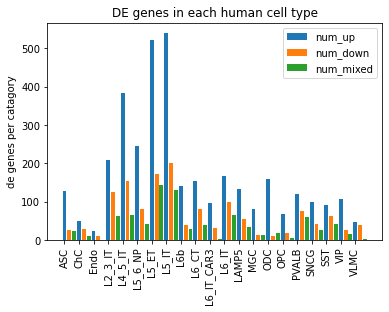

In [36]:
use = overview.loc[(overview.species =='human') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each human cell type')

Text(0.5, 1.0, 'DE genes in each macaque cell type')

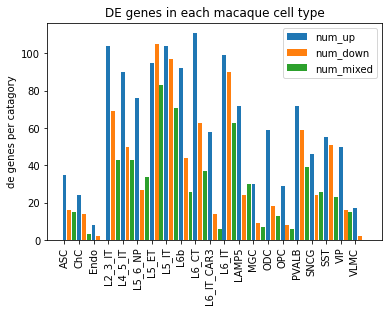

In [37]:
use = overview.loc[(overview.species =='macaque') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each macaque cell type')

Text(0.5, 1.0, 'DE genes in each marmoset cell type')

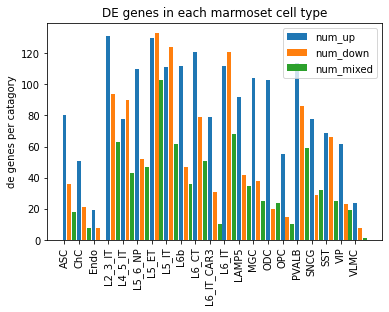

In [38]:
use = overview.loc[(overview.species =='marmoset') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each marmoset cell type')

Text(0.5, 1.0, 'DE genes in each mouse cell type')

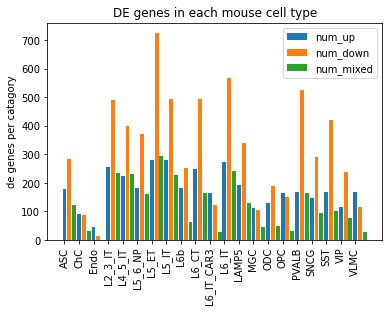

In [39]:
use = overview.loc[(overview.species =='mouse') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each mouse cell type')

In [40]:
overview.shape

(84, 6)

# compare to old analysis

In [43]:
fdr_thresh = .001/120
percent_thresh = .1
nums = []
for test in tests:
    for clust in clusts:
        for spec1 in species:
            spec1_percent = percent_expressed[spec1][clust]
            spec_list_up = []
            spec_list_down = []
            spec_list_mixed = []
            for spec2 in species:
                # print(spec1, spec2)
                if spec1 == spec2:
                    continue
                spec2_percent = percent_expressed[spec2][clust]
                
                f_use = in_f.format(test, spec1, spec2, clust)
                dat = pd.read_csv(f_use, sep='\t')
                sig_up = dat.index[(dat.FDR < fdr_thresh) & (dat.logFC >np.log2(3))].values
                sig_up = spec1_percent.index[(spec1_percent > .15) & spec1_percent.index.isin(sig_up)].values.tolist()
                sig_down = dat.index[(dat.FDR < fdr_thresh) & (dat.logFC < np.log2(3))].values
                sig_down = spec2_percent.index[(spec2_percent > .15) & spec2_percent.index.isin(sig_down)].values.tolist()
                
                # print('here')
                spec_list_up.append(sig_up)
                spec_list_down.append(sig_down)
                spec_list_mixed.append(sig_up + sig_down)
                # spec_list_signs.append([True] * len(sig_up) + [False]*len(sig_down))
                # save_list(out_go_pair.format(spec1, spec2, clust, 'down', test), sig_down)
                # save_list(out_go_pair.format(spec1, spec2, clust, 'up', test), sig_up)
            species_spec_up = list_intersection(spec_list_up)
            species_spec_down = list_intersection(spec_list_down)
            species_spec_mixed = np.setdiff1d(np.setdiff1d(list_intersection(spec_list_mixed),
                                              species_spec_up),
                                              species_spec_down)
            # save_list(out_go_specific.format(spec1, clust, 'up', test), species_spec_up)
            # save_list(out_go_specific.format(spec1, clust, 'down', test), species_spec_down)
            # save_list(out_go_specific.format(spec1, clust, 'mixed', test), species_spec_mixed)
            # print(spec1)
            nums.append([clust, spec1, test, len(species_spec_up), len(species_spec_down), len(species_spec_mixed)])
        # background = dat.index.values
        # if test == 'lrt':
            # print(clust, len(background))
            # save_list(bg_genes.format(clust), background)

In [44]:
overview2 = pd.DataFrame(nums, columns = ['cell_type', 'species', 'test', 'num_up', 'num_down', 'num_mixed'])

Text(0.5, 1.0, 'DE genes in each human cell type')

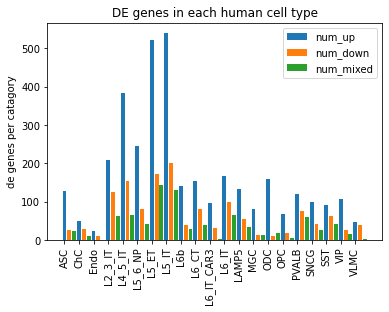

In [47]:
use = overview2.loc[(overview2.species =='human') & (overview2.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each human cell type')

Text(0.5, 1.0, 'DE genes in each macaque cell type')

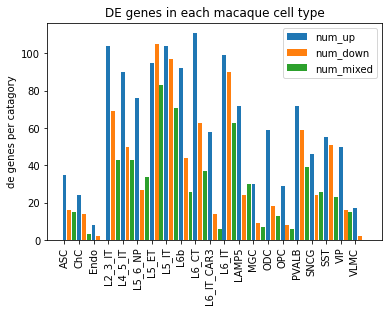

In [48]:
use = overview2.loc[(overview2.species =='macaque') & (overview2.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each macaque cell type')

Text(0.5, 1.0, 'DE genes in each marmoset cell type')

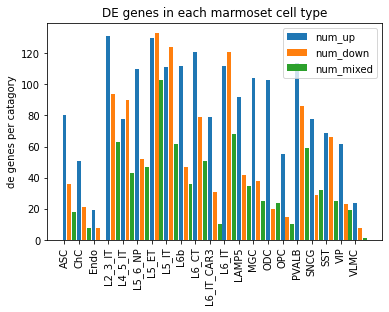

In [50]:
use = overview2.loc[(overview2.species =='marmoset') & (overview2.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each marmoset cell type')

Text(0.5, 1.0, 'DE genes in each mouse cell type')

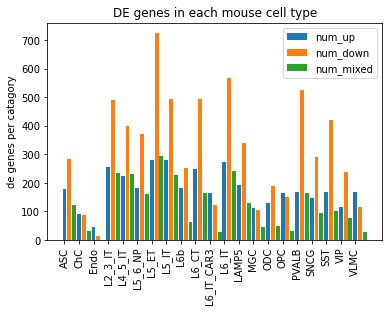

In [51]:
use = overview.loc[(overview.species =='mouse') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each mouse cell type')

Text(0.5, 1.0, 'DE genes in each human cell type')

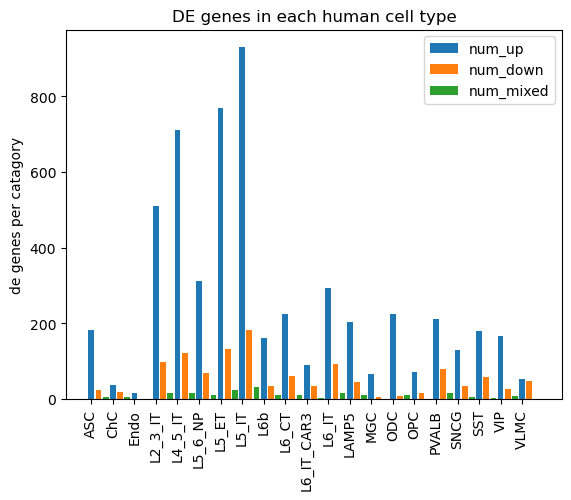

In [50]:
use = overview.loc[(overview.species =='human') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each human cell type')

Text(0.5, 1.0, 'DE genes in each macaque cell type')

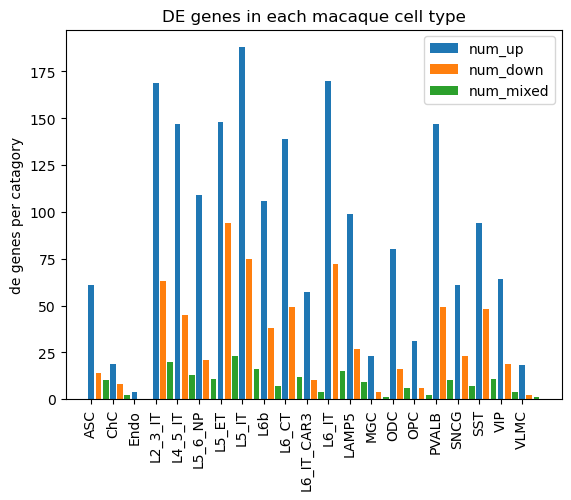

In [51]:
use = overview.loc[(overview.species =='macaque') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each macaque cell type')

Text(0.5, 1.0, 'DE genes in each marmoset cell type')

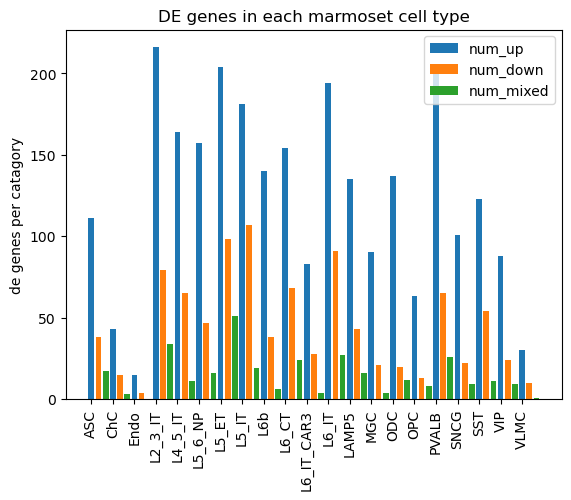

In [52]:
use = overview.loc[(overview.species =='marmoset') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each marmoset cell type')

Text(0.5, 1.0, 'DE genes in each mouse cell type')

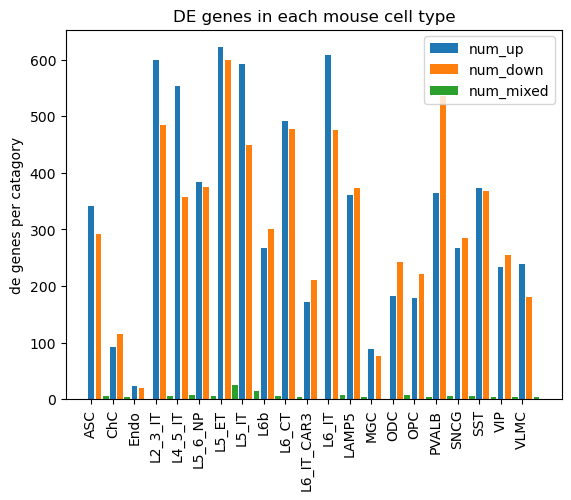

In [53]:
use = overview.loc[(overview.species =='mouse') & (overview.test == 'lrt')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each mouse cell type')

Text(0.5, 1.0, 'DE genes in each human cell type')

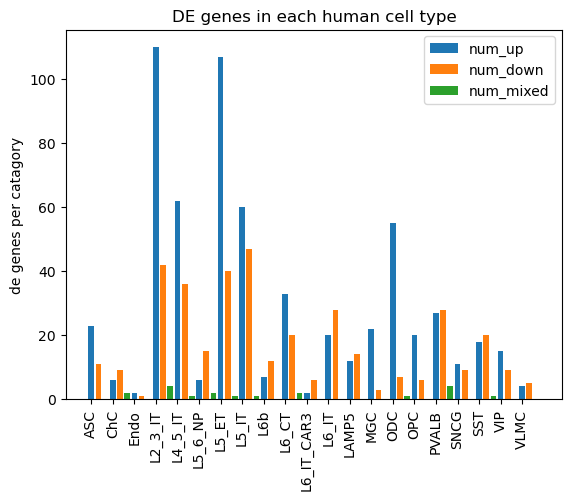

In [54]:
use = overview.loc[(overview.species =='human') & (overview.test == 'qlf_robust')]
count = 0
for catagory in ['num_up', 'num_down', 'num_mixed']:
    plt.bar(np.arange(0, 63, 3) + count, use[catagory].values, label=catagory)
    count+= 1
ticks = plt.xticks(np.arange(0, 63, 3), labels= clusts, rotation=90)
plt.ylabel('de genes per catagory')
plt.legend()
plt.title('DE genes in each human cell type')

# atac

In [11]:
tests = ['lrt', 'lrt_robust', 'qlf', 'qlf_robust']

In [12]:
for test in tests:
    !mkdir -p ../../data/outputs/atac_de_results/$test/aggregate

In [13]:
species = ['human', 'macaque', 'marmoset', 'mouse']

In [14]:
in_f = '../../data/outputs/atac_de_results/{0}/{1}_v_{2}_{3}.tsv'

In [15]:
out_f = '../../data/outputs/atac_de_results/{0}/aggregate/{1}_v_{2}_logfc.tsv'

# aggregate fold change global

In [16]:
spec_use = species + ['all']

In [17]:
clusts = clusts[:clusts.index('ChC')] + clusts[clusts.index('ChC')+1:]

In [18]:
for test in tests:
    for spec1 in species:
        for spec2 in spec_use:
            if spec1 == spec2:
                continue
            dfs = []
            for clust in clusts:
                f_use = in_f.format(test, spec1, spec2, clust)
                dfs.append(pd.read_csv(f_use, sep='\t')['logFC'])
                # !wc -l $f_use
            df_out = pd.concat(dfs, axis=1)
            df_out.columns = clusts
            df_out.to_csv(out_f.format(test, spec1, spec2), sep='\t')